<a href="https://colab.research.google.com/github/onurtuncay/FinancialSentimentAnalysis/blob/main/OOP_Dissertation_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Necessary Libraries

In [ ]:
!pip install numpy==1.26.4
!pip install evaluate
#!pip install -U transformers==4.40.1 trl==0.7.10 peft==0.10.0 accelerate bitsandbytes
!pip install -U  transformers trl==0.7.10 peft accelerate bitsandbytes

  Using cached transformers-4.51.3-py3-none-any.whl.metadata (38 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached transformers-4.51.3-py3-none-any.whl (10.4 MB)
Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.28.0
    Uninstalling transformers-4.28.0:
      Successfully uninstalled transformers-4.28.0


In [ ]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk import word_tokenize, ngrams
from typing import Optional, Dict, List, Tuple
from sklearn.model_selection import train_test_split
import torch
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, ConfusionMatrixDisplay, classification_report
import wandb
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Functions

In [ ]:
def wandb_login():
    """
    Logs into Weights & Biases (wandb) using a predefined API key.

    This function attempts to authenticate the user with wandb using a hardcoded API key.
    If the login process fails, it will raise an exception.

    Returns:
        None

    Raises:
        Exception: If authentication fails.
    """
    try:
        wandb.login(key="db3478ba979cbd1867ff16ba463f15aaea3825f4")  # Replace key value with your actual API key
    except Exception as e:
        print(f"Failed to login to wandb: {e}")

In [ ]:
def load_financial_phrasebank(source):
    """
    Loads the Financial PhraseBank dataset from either a local CSV file or Hugging Face.

    Args:
        source (str): Path to a local CSV file or "huggingface" to fetch from Hugging Face.

    Returns:
        pd.DataFrame: The loaded dataset as a Pandas DataFrame.

    Raises:
        Exception: If the dataset fails to load from either source.
    """
    try:
        if source.lower() == "huggingface":
            dataset = load_dataset("takala/financial_phrasebank", "sentences_50agree")
            df = dataset["train"].to_pandas()
            print("Successfully loaded dataset from Hugging Face.")
        else:
            df = pd.read_csv(source, index_col=0)
            print(f" Successfully loaded dataset from local file: {source}")

        return df

    except Exception as e:
        print(f" Failed to load dataset: {e}")
        return None


In [ ]:
def quick_eda(df: pd.DataFrame) -> None:
    """
    Perform a quick exploratory data analysis (EDA) on a pandas DataFrame.

    This function displays:
    1. The first 5 rows of the DataFrame (df.head())
    2. The shape of the DataFrame (df.shape)
    3. Information about the DataFrame including dtypes and non-null counts (df.info())
    4. Statistical summary of numerical columns (df.describe())

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to analyze

    Returns:
    --------
    None
        This function prints results but doesn't return anything

    Raises:
    -------
    TypeError
        If the input is not a pandas DataFrame
    Exception
        For other unexpected errors during execution
    """

    try:
        # Check if input is a DataFrame
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        print("="*50)
        print("1. FIRST 5 ROWS".center(50))
        print("="*50)
        display(df.head())

        print("\n" + "="*50)
        print("2. DATAFRAME SHAPE".center(50))
        print("="*50)
        print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

        print("\n" + "="*50)
        print("3. DATAFRAME INFO".center(50))
        print("="*50)
        df.info()

        print("\n" + "="*50)
        print("4. STATISTICAL SUMMARY".center(50))
        print("="*50)
        display(df.describe(include='all'))

    except Exception as e:
        print(f"An error occurred during EDA: {str(e)}")
        raise

In [ ]:
def handle_duplicates(df: pd.DataFrame, subset=None, keep='first', inplace=False):
    """
    Identify, report, and remove duplicate rows from a pandas DataFrame.

    This function:
    1. Identifies duplicate rows (optionally considering specific columns)
    2. Reports the number of duplicate rows found
    3. Removes duplicates according to specified parameters
    4. Returns the cleaned DataFrame (or None if inplace=True)

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to process
    subset : column label or sequence of labels, optional
        Only consider certain columns for identifying duplicates
    keep : {'first', 'last', False}, default 'first'
        - 'first' : Mark duplicates as True except for the first occurrence
        - 'last' : Mark duplicates as True except for the last occurrence
        - False : Mark all duplicates as True
    inplace : bool, default False
        Whether to modify the DataFrame in place or return a new DataFrame

    Returns:
    --------
    pandas.DataFrame or None
        DataFrame with duplicates removed or None if inplace=True

    Raises:
    -------
    TypeError
        If the input is not a pandas DataFrame
    ValueError
        If invalid parameters are provided
    Exception
        For other unexpected errors during execution
    """

    try:
        # Check if input is a DataFrame
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        print("="*50)
        print("DUPLICATE HANDLING PROCESS".center(50))
        print("="*50)

        # Count duplicates
        duplicates = df.duplicated(subset=subset, keep=keep)
        duplicate_count = duplicates.sum()

        print(f"\nFound {duplicate_count} duplicate row(s)")

        if duplicate_count > 0:
            print("\nSample duplicate rows:")
            display(df[duplicates].head())

            if inplace:
                df.drop_duplicates(subset=subset, keep=keep, inplace=True)
                print(f"\nRemoved {duplicate_count} duplicate row(s) (inplace operation)")
                return None
            else:
                cleaned_df = df.drop_duplicates(subset=subset, keep=keep)
                print(f"\nRemoved {duplicate_count} duplicate row(s)")
                return cleaned_df
        else:
            print("\nNo duplicates found - returning original DataFrame")
            return df if not inplace else None

    except Exception as e:
        print(f"\nAn error occurred during duplicate handling: {str(e)}")
        raise

In [ ]:
def add_sentiment_column(
    df: pd.DataFrame,
    label_col: str = "label",
    output_col: str = "sentiment",
    mapping: dict = {0: "negative", 1: "neutral", 2: "positive"},
    inplace: bool = False) :
    """
    Maps numerical sentiment labels to descriptive strings and adds a new column.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing sentiment labels
    label_col : str, optional
        Name of the column containing numerical labels (default: "label")
    output_col : str, optional
        Name of the new column to be created (default: "sentiment")
    mapping : dict, optional
        Dictionary mapping numerical values to descriptions
        (default: {0: "negative", 1: "neutral", 2: "positive"})
    inplace : bool, optional
        If True, modifies the DataFrame in-place (default: False)

    Returns:
    --------
    pandas.DataFrame or None
        Returns DataFrame with new sentiment column if inplace=False,
        otherwise returns None and modifies the DataFrame in-place

    Raises:
    -------
    KeyError
        If the specified label_col doesn't exist in the DataFrame
    TypeError
        If input is not a pandas DataFrame or mapping is not a dictionary
    ValueError
        If mapping dictionary is empty
    """

    try:
        # Input validation
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")
        if not isinstance(mapping, dict):
            raise TypeError("Mapping must be a dictionary")
        if not mapping:
            raise ValueError("Mapping dictionary cannot be empty")
        if label_col not in df.columns:
            raise KeyError(f"Column '{label_col}' not found in DataFrame")

        # Create a copy if not operating inplace
        if not inplace:
            df = df.copy()

        # Map the values and create new column
        df[output_col] = df[label_col].map(mapping)

        # Validate mapping covered all labels
        unmapped = df[output_col].isna().sum()
        if unmapped > 0:
            print(f"Warning: {unmapped} labels were not found in the mapping dictionary")

        if not inplace:
            return df

    except Exception as e:
        print(f"Error in add_sentiment_column: {str(e)}")
        raise

In [ ]:
def visualize_text_analysis(
    df: pd.DataFrame,
    text_col: str = "sentence",
    sentiment_col: str = "sentiment",
    figsize: tuple = (15, 10),
    token_count_bins: int = 10,
    wordcloud_dimensions: tuple = (800, 400),
    show_individual_wordclouds: bool = True,
    nltk_download: bool = True,
    top_n: int = 25,
    show_ngrams: bool = True
):
    """
    Perform comprehensive text analysis visualizations including:
    1. Token count distribution
    2. Sentiment label distribution (pie chart)
    3. WordCloud for entire dataset
    4. Individual WordClouds for each sentiment (optional)
    5. N-gram analysis (single words, bigrams, trigrams)

    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame containing text and sentiment data
    text_col : str, optional
        Name of the column containing text data (default: "sentence")
    sentiment_col : str, optional
        Name of the column containing sentiment labels (default: "sentiment")
    figsize : tuple, optional
        Base figure size for plots (default: (15, 10))
    token_count_bins : int, optional
        Number of bins for token count histogram (default: 10)
    wordcloud_dimensions : tuple, optional
        Dimensions for WordCloud images (width, height) (default: (800, 400))
    show_individual_wordclouds : bool, optional
        Whether to show individual WordClouds per sentiment (default: True)
    nltk_download : bool, optional
        Whether to download NLTK punkt tokenizer (default: True)
    top_n : int, optional
        Number of top n-grams to display (default: 25)
    show_ngrams : bool, optional
        Whether to show n-gram analysis (default: True)

    Returns:
    --------
    None
        This function only displays visualizations

    Raises:
    -------
    KeyError
        If specified text_col or sentiment_col doesn't exist
    TypeError
        If input is not a pandas DataFrame
    ImportError
        If required packages are not installed
    """

    def plot_counts(data: Dict[str, int], title: str, color: str) -> None:
        """Helper function to plot horizontal bar charts for n-grams"""
        plt.figure(figsize=(figsize[0]//2, figsize[1]//2))
        sorted_data = dict(sorted(data.items(), key=lambda item: item[1]))
        plt.barh(list(sorted_data.keys()), list(sorted_data.values()), color=color)
        plt.title(title)
        plt.xlabel("Count")
        plt.ylabel("Words/Word Groups")
        plt.gca().invert_yaxis()  # Invert y-axis to have the most common on top
        plt.tight_layout()
        plt.show()

    try:
        # Input validation
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        for col in [text_col, sentiment_col]:
            if col not in df.columns:
                raise KeyError(f"Column '{col}' not found in DataFrame")

        # Download NLTK data if needed
        if nltk_download:
            nltk.download('punkt', quiet=True)

        # 1. Token Count Analysis
        print("\n" + "="*50)
        print("TOKEN COUNT ANALYSIS".center(50))
        print("="*50)

        df['token_count'] = df[text_col].apply(lambda x: len(word_tokenize(str(x))))

        plt.figure(figsize=(figsize[0], figsize[1]//2))
        sns.histplot(df['token_count'], bins=token_count_bins, kde=True, color='blue')
        plt.xlabel("Token Count")
        plt.ylabel("Frequency")
        plt.title(f"Token Count Distribution in {text_col} Column")
        plt.show()

        # 2. Sentiment Distribution
        print("\n" + "="*50)
        print("SENTIMENT DISTRIBUTION".center(50))
        print("="*50)

        label_counts = df[sentiment_col].value_counts()

        plt.figure(figsize=(8, 8))
        plt.pie(label_counts, labels=label_counts.index,
                autopct='%1.1f%%', startangle=90)
        plt.title("Distribution of Sentiment Labels")
        plt.show()

        # 3. WordCloud - Entire Dataset
        print("\n" + "="*50)
        print("WORD CLOUD - FULL DATASET".center(50))
        print("="*50)

        text = " ".join(df[text_col].astype(str))
        wordcloud = WordCloud(
            width=wordcloud_dimensions[0],
            height=wordcloud_dimensions[1],
            background_color="white"
        ).generate(text)

        plt.figure(figsize=(figsize[0], figsize[1]//2))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"WordCloud - Entire Dataset ({len(df)} texts)")
        plt.show()

        # 4. Individual WordClouds by Sentiment
        if show_individual_wordclouds:
            print("\n" + "="*50)
            print("WORD CLOUDS BY SENTIMENT".center(50))
            print("="*50)

            sentiments = df[sentiment_col].unique()
            n_sentiments = len(sentiments)

            plt.figure(figsize=(figsize[0], figsize[1]//2))

            for i, sentiment in enumerate(sentiments, 1):
                subset = df[df[sentiment_col] == sentiment]
                text = " ".join(subset[text_col].astype(str))

                if text.strip():  # Only generate if text exists
                    wordcloud = WordCloud(
                        width=wordcloud_dimensions[0]//2,
                        height=wordcloud_dimensions[1]//2,
                        background_color="white"
                    ).generate(text)

                    plt.subplot(1, n_sentiments, i)
                    plt.imshow(wordcloud, interpolation="bilinear")
                    plt.axis("off")
                    plt.title(f"{sentiment}\n(n={len(subset)})")

            plt.tight_layout()
            plt.show()

        # 5. N-gram Analysis
        if show_ngrams:
            print("\n" + "="*50)
            print("N-GRAM ANALYSIS".center(50))
            print("="*50)

            sentences = df[text_col].astype(str).tolist()

            # Single words
            words = [word.lower() for sentence in sentences
                    for word in word_tokenize(sentence)]
            most_common_words = dict(Counter(words).most_common(top_n))
            print("\nMost Common Single Words:")
            print(most_common_words)
            plot_counts(most_common_words, f"Top {top_n} Single Words by Count", "skyblue")

            # Bigrams
            bigrams = [" ".join(bigram) for sentence in sentences
                      for bigram in ngrams(word_tokenize(sentence.lower()), 2)]
            most_common_bigrams = dict(Counter(bigrams).most_common(top_n))
            print("\nMost Common Bigrams:")
            print(most_common_bigrams)
            plot_counts(most_common_bigrams, f"Top {top_n} Bigrams by Count", "lightcoral")

            # Trigrams
            trigrams = [" ".join(trigram) for sentence in sentences
                       for trigram in ngrams(word_tokenize(sentence.lower()), 3)]
            most_common_trigrams = dict(Counter(trigrams).most_common(top_n))
            print("\nMost Common Trigrams:")
            print(most_common_trigrams)
            plot_counts(most_common_trigrams, f"Top {top_n} Trigrams by Count", "mediumseagreen")

    except ImportError as e:
        print(f"Missing required package: {str(e)}")
        print("Please install with: pip install wordcloud nltk seaborn matplotlib")
    except Exception as e:
        print(f"Error during visualization: {str(e)}")
        raise

In [ ]:
def stratified_split_data(
    df: pd.DataFrame,
    sentiment_col: str = 'sentiment',
    train_size: float = 0.7,
    val_test_ratio: float = 0.5,
    random_state: int = 42,
    verbose: bool = True
):
    """
    Perform stratified train-val-test split on a DataFrame.

    Splits the data into training, validation, and test sets while preserving
    the class distribution in each split.

    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame to be split
    sentiment_col : str, optional
        Name of the column containing sentiments (default: 'sentiment')
    train_size : float, optional
        Proportion of dataset to include in train split (default: 0.7)
    val_test_ratio : float, optional
        Ratio of validation to test in the remaining data after train split (default: 0.5)
    random_state : int, optional
        Random seed for reproducibility (default: 42)
    verbose : bool, optional
        Whether to print split sizes (default: True)

    Returns:
    --------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        Returns (train_df, val_df, test_df) DataFrames

    Raises:
    -------
    ValueError
        If train_size is not between 0 and 1
        If val_test_ratio is not between 0 and 1
        If sentiment doesn't exist in DataFrame
    """

    # Input validation
    if not 0 < train_size < 1:
        raise ValueError("train_size must be between 0 and 1")
    if not 0 < val_test_ratio < 1:
        raise ValueError("val_test_ratio must be between 0 and 1")
    if sentiment_col not in df.columns:
        raise ValueError(f"Column '{sentiment_col}' not found in DataFrame")

    try:
        # First split: train vs temp (val+test)
        train_df, temp_df = train_test_split(
            df,
            test_size=1-train_size,
            stratify=df[sentiment_col],
            random_state=random_state
        )

        # Second split: val vs test
        val_df, test_df = train_test_split(
            temp_df,
            test_size=val_test_ratio,
            stratify=temp_df[sentiment_col],
            random_state=random_state
        )

        if verbose:
            print(f"Train: {train_df.shape[0]:,} samples ({train_size*100:.0f}%)")
            print(f"Validation: {val_df.shape[0]:,} samples ({(1-train_size)*val_test_ratio*100:.0f}%)")
            print(f"Test: {test_df.shape[0]:,} samples ({(1-train_size)*(1-val_test_ratio)*100:.0f}%)")
            print(f"\nClass distribution (%):")
            print("Train:\n", train_df[sentiment_col].value_counts(normalize=True)*100)
            print("\nValidation:\n", val_df[sentiment_col].value_counts(normalize=True)*100)
            print("\nTest:\n", test_df[sentiment_col].value_counts(normalize=True)*100)

        return train_df, val_df, test_df

    except Exception as e:
        print(f"Error during stratified splitting: {str(e)}")
        raise

In [ ]:
def get_device(device_name: Optional[str] = None, verbose: bool = True):
    """
    Get the appropriate torch device (CUDA/CPU) with optional preference and validation.

    Parameters:
    -----------
    device_name : str, optional
        Preferred device ('cuda', 'cpu', or None for auto-detection)
    verbose : bool, optional
        Whether to print device information (default: True)

    Returns:
    --------
    torch.device
        The selected computing device

    Raises:
    -------
    RuntimeError
        If requested device is not available
    """
    try:
        # Auto-detect if no preference specified
        if device_name is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            device = torch.device(device_name)

            # Validate device availability
            if device.type == 'cuda' and not torch.cuda.is_available():
                raise RuntimeError("CUDA requested but not available")

        if verbose:
            print(f"Using device: {device}")
            if device.type == 'cuda':
                print(f"GPU Name: {torch.cuda.get_device_name(0)}")
                print(f"Memory Allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
                print(f"Memory Cached: {torch.cuda.memory_reserved()/1024**2:.2f} MB")

        return device

    except Exception as e:
        print(f"Error setting up device: {str(e)}")
        print("Falling back to CPU")
        return torch.device("cpu")

In [ ]:
def initialize_model_and_tokenizer(model_name, tokenizer_name=None, device=None, num_labels=3):
    """
    Initialize tokenizer and model for given pretrained models

    Args:
        model_name: HuggingFace model path for model (e.g., "ProsusAI/finbert")
        tokenizer_name: HuggingFace model path for tokenizer (if different from model)
        device: torch device (cuda/cpu), if None will auto-detect
        num_labels: Number of output classes

    Returns:
        tokenizer, model
    """
    # Auto-detect device if not specified
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Use separate tokenizer name if provided, otherwise use model_name
    tokenizer_model_name = tokenizer_name if tokenizer_name is not None else model_name

    tokenizer = AutoTokenizer.from_pretrained(tokenizer_model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    model.to(device)
    return tokenizer, model

def prepare_datasets(df_dict, tokenizer, text_col="sentence", label_col="label"):
    """
    Convert pandas DataFrames to tokenized datasets

    Args:
        df_dict: Dictionary of DataFrames {'train': train_df, 'val': val_df, 'test': test_df}
        tokenizer: HuggingFace tokenizer
        text_col: Name of text column
        label_col: Name of label column

    Returns:
        Dictionary of processed datasets
    """
    def tokenize_function(examples):
        return tokenizer(examples[text_col], padding="max_length", truncation=True, max_length=512)

    datasets = {}
    for split, df in df_dict.items():
        dataset = Dataset.from_pandas(df)
        dataset = dataset.map(tokenize_function, batched=True)
        dataset = dataset.rename_column(label_col, "labels")
        dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
        datasets[split] = dataset

    return datasets

def compute_metrics(p):
    """
    Compute classification metrics for evaluation

    Args:
        p: Trainer prediction object

    Returns:
        Dictionary of metrics
    """
    preds = torch.argmax(torch.tensor(p.predictions), dim=1)
    labels = torch.tensor(p.label_ids)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

def plot_results(predictions, true_labels, model_name):
    """
    Plot confusion matrix and print classification report

    Args:
        predictions: Model predictions
        true_labels: Ground truth labels
        model_name: Name for plot title
    """
    preds = np.argmax(predictions, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=["negative", "neutral", "positive"])
    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(ax=ax, cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Classification Report
    print(f"\nClassification Report - {model_name}:\n")
    print(classification_report(true_labels, preds,
                              target_names=["negative", "neutral", "positive"]))

def train_and_evaluate(model_name, df_dict, device=None, output_dir="./results", tokenizer_name=None):
    """
    End-to-end training and evaluation pipeline

    Args:
        model_name: HuggingFace model path for model
        df_dict: Dictionary of DataFrames
        device: torch device (optional)
        output_dir: Output directory for results
        tokenizer_name: HuggingFace model path for tokenizer (if different from model)

    Returns:
        trainer: Trained Trainer object
        metrics: Evaluation metrics
    """
    # Initialize
    tokenizer, model = initialize_model_and_tokenizer(
        model_name=model_name,
        tokenizer_name=tokenizer_name,
        device=device
    )
    datasets = prepare_datasets(df_dict, tokenizer)

    f1_metric = evaluate.load("f1")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
        return {"f1": f1["f1"]}

    training_args = TrainingArguments(
        output_dir = output_dir,
        run_name=f"{model_name.replace('/', '_')}_run",
        do_train=True,
        do_eval=True,
        eval_steps=100,
        save_steps=100,
        save_total_limit=2,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        num_train_epochs=4,
        learning_rate=2e-5,
        weight_decay=0.01,
        logging_steps=25,
        load_best_model_at_end=False,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        report_to="none"
)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=datasets["train"],
        eval_dataset=datasets["val"],
        compute_metrics=compute_metrics
    )

    # Training
    trainer.train()

    # Evaluation
    test_results = trainer.predict(datasets["test"])
    print(test_results.metrics)
    plot_results(test_results.predictions, test_results.label_ids, model_name)

    return trainer, test_results.metrics

# Main Start

In [ ]:
df = load_financial_phrasebank("/content/FinancialPhraseBankDataset.csv")  # Load from CSV
# df = load_financial_phrasebank("huggingface")  # Load from huggingface


 Successfully loaded dataset from local file: /content/FinancialPhraseBankDataset.csv


In [ ]:
quick_eda(df)

                 1. FIRST 5 ROWS                  


,sentence,label
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,The international electronic industry company ...,0
3,With the new production plant the company woul...,2
4,According to the company 's updated strategy f...,2



                2. DATAFRAME SHAPE                
Rows: 4846, Columns: 2

                3. DATAFRAME INFO                 
<class 'pandas.core.frame.DataFrame'>
Index: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  4846 non-null   object
 1   label     4846 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 113.6+ KB

              4. STATISTICAL SUMMARY              


,sentence,label
count,4846,4846.000000
unique,4838,NaN
top,TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...,NaN
freq,2,NaN
mean,NaN,1.156624
std,NaN,0.617616
min,NaN,0.000000
25%,NaN,1.000000
50%,NaN,1.000000
75%,NaN,2.000000


In [ ]:
handle_duplicates(df, inplace=True)

            DUPLICATE HANDLING PROCESS            

Found 6 duplicate row(s)

Sample duplicate rows:


,sentence,label
1099,The issuer is solely responsible for the conte...,1
1416,The report profiles 614 companies including ma...,1
2396,Ahlstrom 's share is quoted on the NASDAQ OMX ...,1
2567,SSH Communications Security Corporation is hea...,1
3094,Proha Plc ( Euronext :7327 ) announced today (...,1



Removed 6 duplicate row(s) (inplace operation)


In [ ]:
df

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,The international electronic industry company ...,0
3,With the new production plant the company woul...,2
4,According to the company 's updated strategy f...,2
...,...,...
4841,LONDON MarketWatch -- Share prices ended lower...,0
4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,1
4843,Operating profit fell to EUR 35.4 mn from EUR ...,0
4844,Net sales of the Paper segment decreased to EU...,0


In [ ]:
add_sentiment_column(df, inplace=True)


               TOKEN COUNT ANALYSIS               


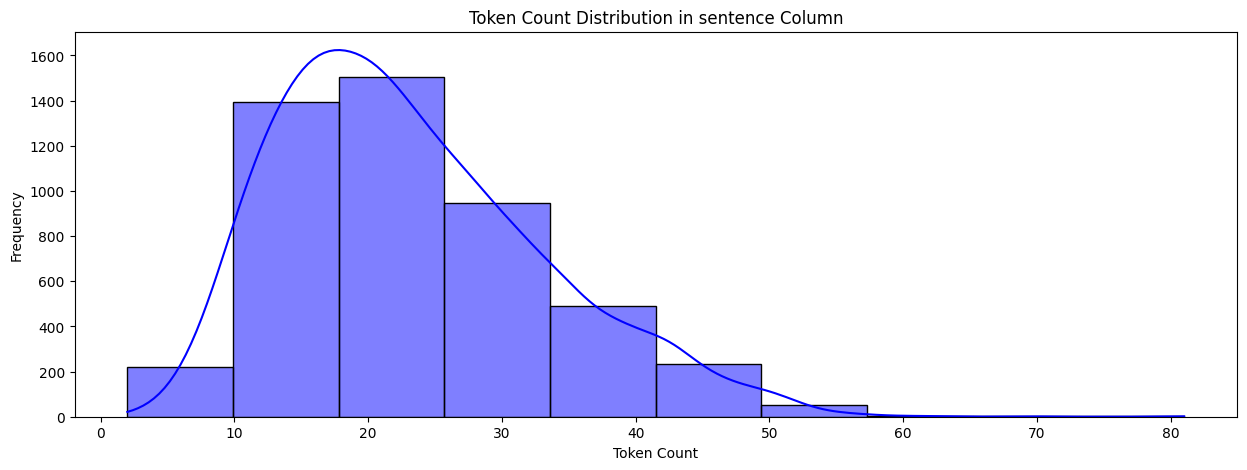


              SENTIMENT DISTRIBUTION              


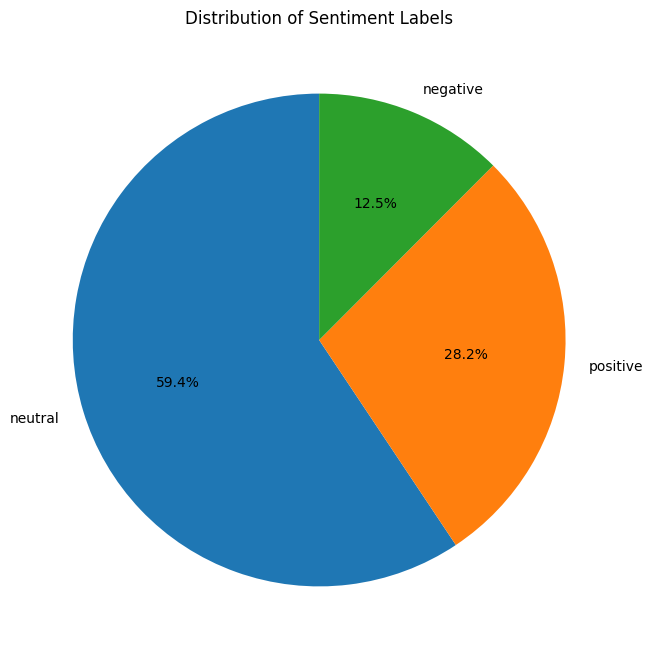


            WORD CLOUD - FULL DATASET             


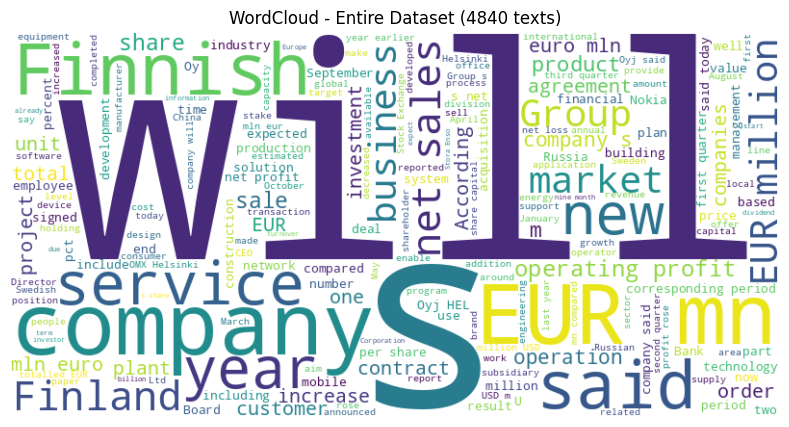


             WORD CLOUDS BY SENTIMENT             


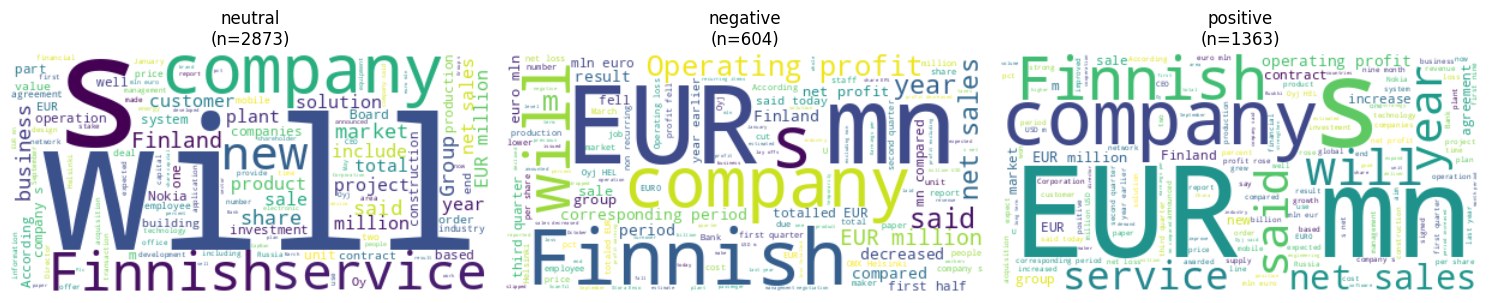


                 N-GRAM ANALYSIS                  

Most Common Single Words:
{'the': 6060, '.': 4840, ',': 4636, 'of': 3211, 'in': 2966, 'and': 2589, 'to': 2507, 'a': 1721, 'for': 1151, 'eur': 1015, "'s": 999, 'is': 927, 'will': 850, 'company': 846, 'from': 769, 'on': 680, 'its': 644, 'has': 577, 'with': 573, 'by': 558, 'said': 545, 'be': 542, 'as': 537, ')': 525, '(': 523}


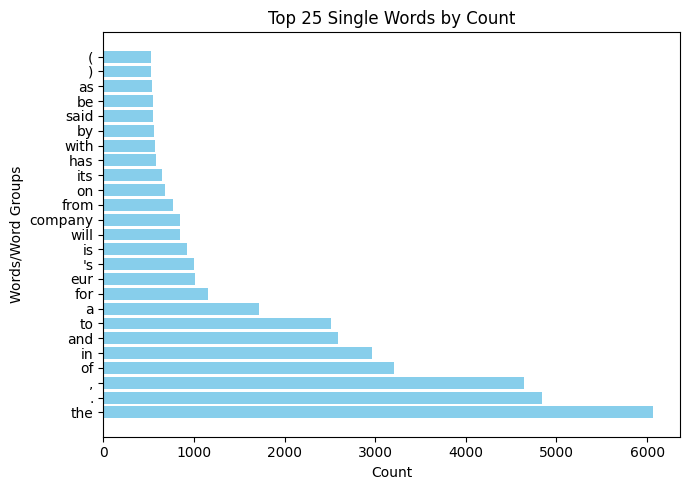


Most Common Bigrams:
{'in the': 802, 'of the': 718, 'the company': 502, ', the': 403, 'for the': 355, ', and': 273, 'will be': 272, 'net sales': 246, 'to the': 241, 'to eur': 227, 'from eur': 210, 'operating profit': 194, 'mn in': 188, 'and the': 182, 'on the': 173, 'the first': 159, 'quarter of': 155, 'in finland': 153, 'to be': 153, 'of eur': 144, "company 's": 139, ', which': 139, '2007 .': 129, '2008 .': 128, 'said .': 125}


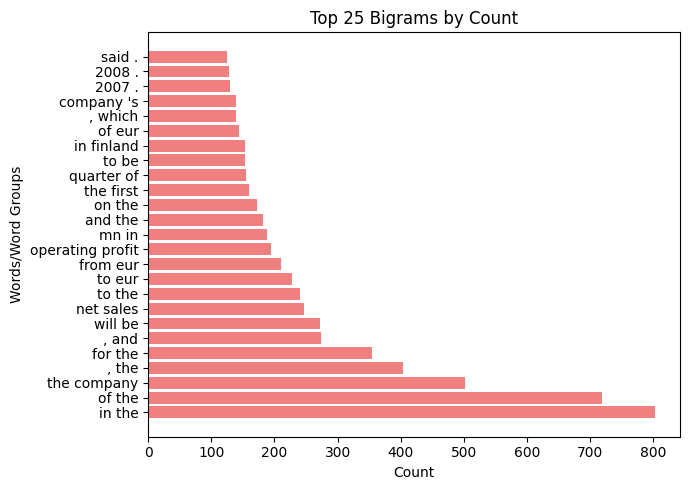


Most Common Trigrams:
{"the company 's": 131, 'mn in the': 120, ', the company': 114, 'the corresponding period': 108, 'corresponding period in': 87, 'as well as': 81, 'in the first': 76, 'mn from eur': 73, 'in the corresponding': 73, 'the end of': 68, 'net sales of': 66, 'euro ( $': 64, 'the first quarter': 58, '( hel :': 58, 'the company said': 57, 'mln euro (': 55, 'the third quarter': 53, 'value of the': 52, 'a year earlier': 51, ', up from': 51, ', compared to': 51, ', finland ,': 50, 'in finland ,': 50, 'the second quarter': 50, 'the same period': 49}


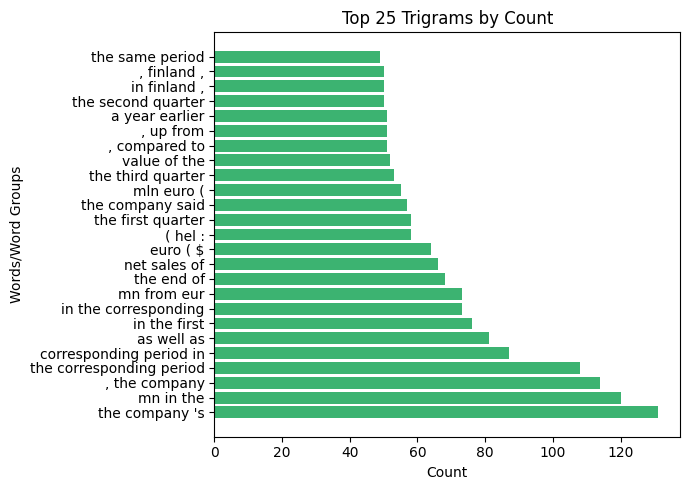

In [ ]:
visualize_text_analysis(df)

In [ ]:
df['sentence']

,sentence
0,"according to gran , the company has no plans t..."
1,technopolis plans to develop in stages an area...
2,the international electronic industry company ...
3,with the new production plant the company woul...
4,according to the company 's updated strategy f...
...,...
4841,london marketwatch -- share prices ended lower...
4842,rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,operating profit fell to eur 35.4 mn from eur ...
4844,net sales of the paper segment decreased to eu...


In [ ]:
# #lowercasing
# df['sentence'] = df['sentence'].str.lower()


In [ ]:
# # Function to remove punctuation
# df['sentence'] = df['sentence'].str.translate(str.maketrans('', '', string.punctuation))

# # Viewing the updated data
# df.head()

In [ ]:
# nltk.download('stopwords')

In [ ]:
# # Import the English stopword list
# stop_words = set(stopwords.words('english'))

# # Function to remove stopwords
# df['sentence'] = df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# # Viewing the updated data
# df.head()

In [ ]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [ ]:
# # Lemmatizer object detinition
# lemmatizer = WordNetLemmatizer()

# # Lemmatization
# df['sentence'] = df['sentence'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# df.head()


In [ ]:
# finance_terms = {
#     "alpha", "alternative minimum tax", "annual report", "annualized", "annualized rate of return",
#     "appreciation", "asset allocation", "asset class", "average maturity", "balanced fund",
#     "bear market", "benchmark", "best-in-class", "beta", "blue chip", "board of trustees",
#     "bond", "bond fund", "breakpoint", "bull market", "capital", "capital gain",
#     "capital gains ex-date", "capital gains long term", "capital gains reinvest nav",
#     "capital gains short term", "capital loss", "capitalization", "cash equivalent",
#     "center for carbon transition", "climate action 100+", "common stock",
#     "contingent deferred sales charge", "corporate bond", "corporate engagement",
#     "corporate social responsibility", "country breakdown", "custodian", "cut-off time",
#     "daily dividend factor", "default", "distribution schedule", "diversification",
#     "dividend", "dividend paid", "dividend reinvest nav", "dividend yield",
#     "dollar cost averaging", "dow jones industrial average", "eps", "equities",
#     "equity fund", "exclusions", "ex-dividend", "ex-dividend date", "exchange privilege",
#     "expense ratio", "federal funds rate", "federal reserve board", "financial materiality",
#     "fixed income fund", "fixed income security", "fund", "green bonds", "green bond principles",
#     "growth investing", "growth stock", "growth-style funds", "impact investing",
#     "investment stewardship", "index", "individual retirement account", "inflation",
#     "interest rate", "interest-rate risk", "investment advisor", "investment company",
#     "investment grade bonds", "investment objective", "junk bond", "large-cap",
#     "letter of intent", "lipper ratings", "liquidity", "loads", "long-term investment strategy",
#     "management fee", "market price", "market risk", "market timing", "maturity",
#     "maturity distribution", "median market cap", "mid-cap", "money market mutual fund",
#     "morningstar ratings", "mutual fund", "nasdaq", "net asset value per share",
#     "number of holdings", "p/b ratio", "paris agreement", "par value", "portfolio",
#     "portfolio allocation", "portfolio holdings", "portfolio manager", "positive tilt",
#     "power purchase agreements", "preferred stock", "premium", "price-to-book",
#     "price-to-earnings ratio", "p/e ratio", "prospectus", "proxy", "public offering price",
#     "quality distribution", "r2", "ratings", "recession", "redemption", "reinvestment option",
#     "relative risk and potential return", "renewable energy certificates", "rights of accumulation",
#     "risk tolerance", "sales charge", "sector", "sector breakdown", "securities",
#     "securities and exchange commission", "share", "share class net assets", "share classes",
#     "sharpe ratio", "short-term investment", "small-cap", "social bonds",
#     "standard & poor's index", "standard deviation", "statement of additional information",
#     "stock", "stockholder", "sustainability accounting standards board", "sustainability bonds",
#     "sustainable development goals", "sustainable investing", "sustainability-linked bonds",
#     "systematic investment plan", "task force on climate-related financial disclosures",
#     "tax-exempt income", "thematic", "time horizon", "top 10 holdings",
#     "top 10 long and short positions", "top five contributors", "top five detractors",
#     "top five holdings", "top five industries", "total return", "tracking error",
#     "transfer agent", "treasury bill", "treasury bond", "treasury note", "treasury security",
#     "trustee", "turnover ratio", "united nations-convened net-zero asset owner alliance",
#     "united nations global compact", "united nations-supported principles for responsible investment",
#     "valuation", "value investing", "value stock", "value-style funds", "volatility",
#     "wtd. avg. market cap", "weighted average maturity", "ytd total return", "ytd",
#     "ytd return", "yield", "yield to maturity", "yield to maturity distribution",
#     "12b-1 fee", "30-day sec yield", "52 week high", "52 week low"
# }

In [ ]:

# # Rebuild the text while preserving financial terms
# df['sentence'] = df['sentence'].apply(lambda x: ' '.join([word if word in finance_terms else lemmatizer.lemmatize(word) for word in x.split()]))

# # View the updated data
# df.head()

In [ ]:
# # Function to display expressions containing special characters
# def show_special(text):
#     # Match all characters except letters
#     matches = re.findall(r'[^a-zA-Z\s]+', str(text))
#     return matches if matches else None

# # Find special expressions in each row and display them in a new column
# df['special_expressions'] = df['sentence'].apply(show_special)

# # Display the DataFrame (filter it to show only the special_expressions column if needed)
# print(df[['sentence', 'special_expressions']])

In [ ]:

# # Flatten the lists in the special_expressions column
# flattened_values = df['special_expressions'].explode()

# # Remove NoneType values
# valid_values = flattened_values[flattened_values.notna()]

# # Filter out numeric values and keep only non-numeric ones
# non_numeric_values = valid_values[~valid_values.str.isnumeric()]

# # Count occurrences and sort from most frequent to least
# value_counts = non_numeric_values.value_counts()

# # Display the results
# print(value_counts)

In [ ]:
# import unicodedata

# def remove_accents(text):
#     return ''.join(c for c in unicodedata.normalize('NFKD', text) if not unicodedata.combining(c))

# df['sentence'] = df['sentence'].apply(remove_accents)


In [ ]:
# df['sentence'] = df['sentence'].str.replace(r'[®¦«¬]', '', regex=True)
# df['sentence'] = df['sentence'].str.replace('1⁄4', 'twenty five percent')
# df['sentence'] = df['sentence'].str.replace('£', 'pound')


In [ ]:
train_df, val_df, test_df = stratified_split_data(df)

Train: 3,387 samples (70%)
Validation: 726 samples (15%)
Test: 727 samples (15%)

Class distribution (%):
Train:
 sentiment
neutral     59.344553
positive    28.166519
negative    12.488928
Name: proportion, dtype: float64

Validation:
 sentiment
neutral     59.366391
positive    28.099174
negative    12.534435
Name: proportion, dtype: float64

Test:
 sentiment
neutral     59.422283
positive    28.198074
negative    12.379642
Name: proportion, dtype: float64


In [ ]:
train_df

,sentence,label,sentiment,token_count
2035,roshan 's net sales in 2006 were $ 191 million...,1,neutral,17
1938,managing director 's comments : `` net sales f...,0,negative,30
4615,liora 's got a brand-new bag .,1,neutral,7
3504,according to finnish l+ñnnen tehtaat 's ceo ma...,1,neutral,34
316,`` the second quarter of 2010 was the firstqua...,2,positive,28
...,...,...,...,...
4338,the company says it is difficult to estimate t...,1,neutral,17
92,4 february 2011 - finnish broadband data commu...,2,positive,40
2108,"following the payment made in april , the comp...",1,neutral,22
4771,upm stock fell 3 percent to euro 12.49 $ 17.24...,0,negative,17


# FinBERT Model

In [ ]:
wandb_login()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Using device: cuda
GPU Name: NVIDIA A100-SXM4-40GB
Memory Allocated: 3684.10 MB
Memory Cached: 6584.00 MB


Map:   0%|          | 0/3387 [00:00<?, ? examples/s]

Map:   0%|          | 0/726 [00:00<?, ? examples/s]

Map:   0%|          | 0/727 [00:00<?, ? examples/s]

Step,Training Loss
25,1.744900
50,1.233200
75,0.770100
100,0.786800
125,0.682800
150,0.690200
175,0.528000
200,0.484900
225,0.526000
250,0.509100


{'test_loss': 0.6614420413970947, 'test_f1': 0.879801665410314, 'test_runtime': 2.648, 'test_samples_per_second': 274.546, 'test_steps_per_second': 68.731}


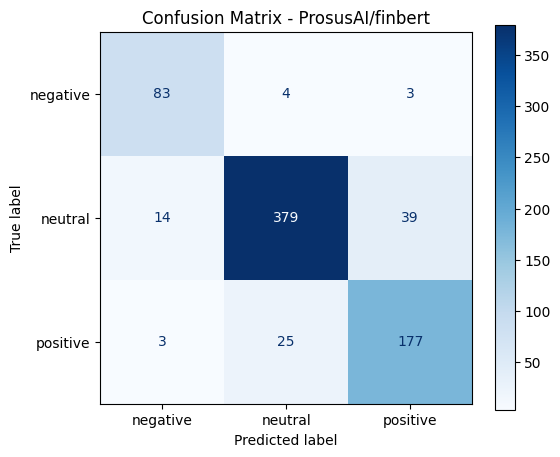


Classification Report - ProsusAI/finbert:

              precision    recall  f1-score   support

    negative       0.83      0.92      0.87        90
     neutral       0.93      0.88      0.90       432
    positive       0.81      0.86      0.83       205

    accuracy                           0.88       727
   macro avg       0.86      0.89      0.87       727
weighted avg       0.88      0.88      0.88       727



In [ ]:
# Defining data
df_dict = {
    'train': train_df,
    'val': val_df,
    'test': test_df
}

device_finbert = get_device(device_name="cuda")

# Run for FinBERT
finbert_trainer, finbert_metrics = train_and_evaluate(
    model_name = "ProsusAI/finbert",
    df_dict = df_dict,
    device = device_finbert,
    output_dir = "./results_finbert",
    tokenizer_name = "ProsusAI/finbert"
)


# FiLM Model

In [ ]:
device_film = get_device(device_name="cuda")


Using device: cuda
GPU Name: NVIDIA A100-SXM4-40GB
Memory Allocated: 3682.40 MB
Memory Cached: 6280.00 MB


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HYdsl/FiLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3387 [00:00<?, ? examples/s]

Map:   0%|          | 0/726 [00:00<?, ? examples/s]

Map:   0%|          | 0/727 [00:00<?, ? examples/s]

Step,Training Loss
25,0.936900
50,1.046800
75,0.894500
100,0.959500
125,0.738100
150,0.796900
175,0.621000
200,0.499300
225,0.538600
250,0.571500


{'test_loss': 0.7311064600944519, 'test_f1': 0.872920080153737, 'test_runtime': 2.7343, 'test_samples_per_second': 265.884, 'test_steps_per_second': 66.562}


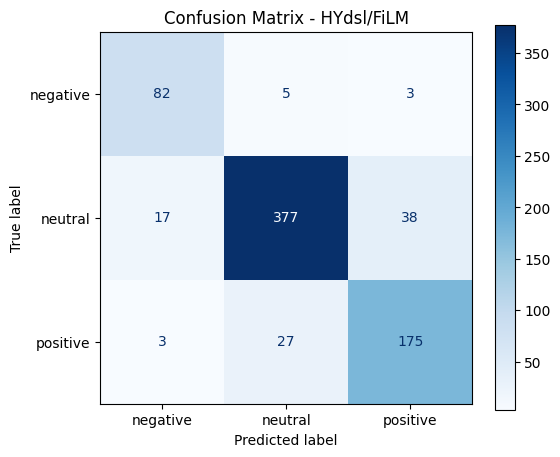


Classification Report - HYdsl/FiLM:

              precision    recall  f1-score   support

    negative       0.80      0.91      0.85        90
     neutral       0.92      0.87      0.90       432
    positive       0.81      0.85      0.83       205

    accuracy                           0.87       727
   macro avg       0.85      0.88      0.86       727
weighted avg       0.88      0.87      0.87       727



In [ ]:

# Run for FiLM
film_trainer, film_metrics = train_and_evaluate(
    model_name = "HYdsl/FiLM",
    df_dict = df_dict,
    device =device_film,
    output_dir="./results_film",
    tokenizer_name = "roberta-base"
)

# QWEN 2.5


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Qwen model ID'si
model_id = "Qwen/Qwen2.5-0.5B"

# Tokenizer ve Model yükle
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token  # GPT tarzı modeller için zorunlu

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

# Eğitim moduna al, gradyanları aç
model.train()
model.enable_input_require_grads()
model.gradient_checkpointing_enable()

# Doğrulama
model.print_trainable_parameters()


trainable params: 540,672 || all params: 494,573,440 || trainable%: 0.1093


In [ ]:
from datasets import Dataset
import random as random
from sklearn.model_selection import train_test_split

# Label → Sentiment eşlemesi
label_map = {0: "negative", 1: "neutral", 2: "positive"}

def format_prompt(row):
    templates = [
        "What is the sentiment of this financial statement:\n\n{sentence}\n\nAnswer:",
        "Analyze the sentiment:\n\n{sentence}\n\nSentiment:",
        "### Instruction:\nClassify the sentiment of the sentence:\n\n{sentence}\n\n### Response:",
        "Determine the tone of the following financial statement:\n\n{sentence}\n\nSentiment Classification:",
        "Assess the sentiment conveyed in this financial news excerpt:\n\n{sentence}\n\nYour Answer:",
        "Sentiment evaluation:\n\n{sentence}\n\nClassification:",
        "Identify the sentiment in the provided financial text:\n\n{sentence}\n\nResponse:",
        "Examine the emotional impact of this financial remark:\n\n{sentence}\n\nSentiment:",
        "Rate the sentiment expressed in the given financial commentary:\n\n{sentence}\n\nAnalysis:",
        "Analyze whether the financial statement is positive, negative, or neutral:\n\n{sentence}\n\nAnswer:"
    ]
    template = random.choice(templates)
    return {
        "text": template.format(sentence=row["sentence"]),
        "label": label_map[row["label"]]
    }


train_data = [format_prompt(row) for _, row in train_df.iterrows()]
val_data = [format_prompt(row) for _, row in val_df.iterrows()]
test_data = [format_prompt(row) for _, row in test_df.iterrows()]

train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)
test_dataset = Dataset.from_list(test_data)


In [ ]:
def tokenize(example):
    # Girdi: Prompt + Label
    full_text = example["text"] + " " + example["label"]

    tokenized = tokenizer(
        full_text,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    input_ids = tokenized["input_ids"][0]
    attention_mask = tokenized["attention_mask"][0]

    labels = input_ids.clone()

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

# Uygula
train_dataset = train_dataset.map(tokenize)
val_dataset = val_dataset.map(tokenize)
test_dataset = test_dataset.map(tokenize)

# PyTorch formatına çevir
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/3387 [00:00<?, ? examples/s]

Map:   0%|          | 0/726 [00:00<?, ? examples/s]

Map:   0%|          | 0/727 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./qwen-sentiment-checkpoints",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=1,
    num_train_epochs=2,
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=25,
    fp16=True,
    gradient_checkpointing=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

trainer.train()


<ipython-input-31-cf2bc3750085>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss
1,0.766100,0.816255
2,0.819800,0.811202


TrainOutput(global_step=1694, training_loss=0.804233966498617, metrics={'train_runtime': 429.4304, 'train_samples_per_second': 15.774, 'train_steps_per_second': 3.945, 'total_flos': 1864753399922688.0, 'train_loss': 0.804233966498617, 'epoch': 2.0})

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm

batch_size = 4  # Daha küçük yapabilirsin (1-2) eğer yine OOM olursa
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
model = model.to("cuda")

all_preds = []
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")

        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=10,
            pad_token_id=tokenizer.pad_token_id
        )

        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        all_preds.extend(decoded)


  3%|▎         | 6/182 [00:01<00:55,  3.20it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
 16%|█▋        | 30/182 [00:09<01:00,  2.53it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
 26%|██▌       | 47/182 [00:14<00:47,  2.84it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tok

              precision    recall  f1-score   support

    negative       0.58      1.00      0.73        90
     neutral       1.00      0.90      0.95       432
    positive       1.00      0.89      0.94       205

    accuracy                           0.91       727
   macro avg       0.86      0.93      0.88       727
weighted avg       0.95      0.91      0.92       727



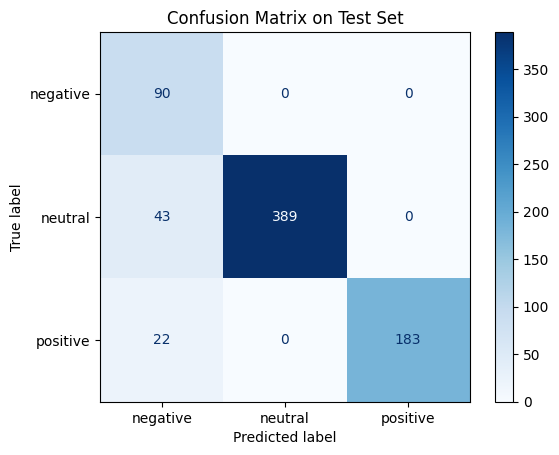

In [ ]:
# Gerçek etiketleri al (zaten test_df içinde var)
actual_text_labels = test_df["sentiment"].tolist()

# Prediction'ları normalize et
def normalize_label(pred):
    for sentiment in ["negative", "neutral", "positive"]:
        if sentiment in pred.lower():
            return sentiment
    return "unknown"

normalized_preds = [normalize_label(pred) for pred in all_preds]

# Filtrele
filtered_true = []
filtered_pred = []
for t, p in zip(actual_text_labels, normalized_preds):
    if p != "unknown":
        filtered_true.append(t)
        filtered_pred.append(p)

# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = ["negative", "neutral", "positive"]
print(classification_report(filtered_true, filtered_pred, labels=labels))

cm = confusion_matrix(filtered_true, filtered_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()


In [ ]:
# Train ve test setinde ortak cümle var mı kontrol et
set_train_sentences = set(train_df['sentence'])
set_test_sentences = set(test_df['sentence'])

common = set_train_sentences.intersection(set_test_sentences)
print(f"Train/Test setlerinde ortak cümle sayısı: {len(common)}")


Train/Test setlerinde ortak cümle sayısı: 1
